# D_family_matching

## Useful functions

In [1]:
from SBL import SBL_pytools
from SBL_pytools import SBL_pytools as sblpyt
help(sblpyt)


Help on class SBL_pytools in module SBL_pytools:

class SBL_pytools(builtins.object)
 |  Static methods defined here:
 |  
 |  convert_eps_to_png(ifname, osize)
 |  
 |  convert_pdf_to_png(ifname, osize)
 |  
 |  find_and_convert(suffix, odir, osize)
 |      # find file with suffix, convert, and return image file
 |  
 |  find_and_show_images(suffix, odir, osize)
 |  
 |  find_file_in_output_directory(suffix, odir)
 |  
 |  show_eps_file(eps_file, osize)
 |  
 |  show_image(img)
 |  
 |  show_log_file(odir)
 |  
 |  show_pdf_file(pdf_file)
 |  
 |  show_row_n_images(images, size)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Toy example:  comparing two clusters

### Options.

We provide a simple example using the executable sbl-cmp-clust-dfam.exe.

The main options of the <b>cmpClusters</b>  in the next cell are:
 - <em>cluster1</em>: Path to the first cluster file
 - <em>cluster2</em>: Path to the second second cluster file
 - <em>method</em>: method (dfam or VI)
     * dfam: using the D_family_matching
     * VI: using the Variation of Information
 
 
 

In [2]:
import re  #regular expressions
import sys #misc system
import os
import pdb
import shutil # python 3 only

import matplotlib.pyplot as plt
import matplotlib.image as mplimg

def cmp_clusters(cluster1, cluster2, method = "dfam"): 
    
    odir = "results-toy-%s" % method
    if os.path.exists(odir):
        os.system("rm -rf %s" % odir)
    os.system( ("mkdir %s" % odir) )

   # check executable exists and is visible
    exe = shutil.which("sbl-cmp-clust-%s.exe" % method)
    if exe:
        print(("Using executable %s\n" % exe))
        cmd = "sbl-cmp-clust-%s.exe -f %s -f %s -d %s --log" % (method, cluster1, cluster2,odir)
        print(cmd)
        os.system(cmd)
        
        cmd = "ls %s/*" % odir
        ofiles = os.popen(cmd).readlines()
        print("All output files:",ofiles)
        
        # we also generate the graph connecting clusters withig meta-clusters, see graph below
        if(method=="dfam"):
            cmd = "dot -Tpdf %s/sbl-d-family-matching__graph.dot -o %s/graph.pdf" % (odir,odir)
            os.system(cmd)
            sblpyt.convert_pdf_to_png( ("%s/graph.pdf" % odir), 150 )
            img=mplimg.imread( ("%s/graph.png" % odir) )
            plt.xticks([]); plt.yticks([])
            imgplot = plt.imshow(img)

        #find the log file and display log file
        #log = open( ("%s/log.txt") % odir).readlines()
        #for line in log:         print(line.rstrip())
        
    else:
        print("Executable not found")
        

Marker : Calculation Started
Using executable /user/fcazals/home/projects/proj-soft/sbl-install/bin/sbl-cmp-clust-dfam.exe

sbl-cmp-clust-dfam.exe -f data/cluster_1.txt -f data/cluster_2.txt -d results-toy-dfam --log
All output files: ['results-toy-dfam/sbl-d-family-matching__clust1_meta_clusters.txt\n', 'results-toy-dfam/sbl-d-family-matching__clust2_meta_clusters.txt\n', 'results-toy-dfam/sbl-d-family-matching__graph.dot\n', 'results-toy-dfam/sbl-d-family-matching__k_family_matching.xml\n', 'results-toy-dfam/sbl-d-family-matching__log.txt\n']
Marker : Calculation Ended


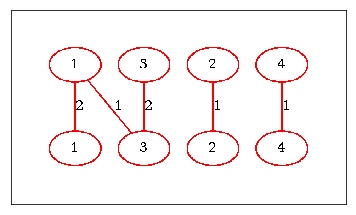

In [3]:
print("Marker : Calculation Started")
#cmp_clusters("data/cluster_1.txt","data/cluster_2.txt", "VI")   
cmp_clusters("data/cluster_1.txt","data/cluster_2.txt")   
print("Marker : Calculation Ended")

## Comparing clusterings produced by kmeans
In the following, we use sbl-cmp-clust-dfam.exe to compare clusterings produced by kmeans. See the package Clustering_engines for the clustering algorithms.

### In the following, we perform the following steps:
* Step 1: prepare the individual clusterings of the datasets
* Step 1b: plot clusterings and collect the images
* Step 2: compute the D-family matchig with the constraint D_max given
* Step 3: create a clustering file from the meta-cluster mapping and the original cluster file
* Step 4: display all results
* Step 5 : extract statistics from xml output file with PALSE
 


In [4]:

import os
import pdb
import sys

from SBL import PALSE
from PALSE import *

#cluster the input data (contained in the .txt file) set into 5 cluster using k-means++
points_files = ["data/points-N200-d50.txt", "data/points-N200-d50.txt"]
k_values = [10, 20]


def run_with_diameter_constraint(D_max):

    odir = "results-%s" % D_max
    if os.path.exists(odir):
        os.system("rm -rf %s" % odir)
    os.system( ("mkdir %s" % odir) )

    # Step 1: prepare the individual clusterings of the datasets
    clusters_files = [] # files containing cluters
    centers_files = [] # files containing cluster centers
    for i in range(0, len(points_files)):
              cmd = "sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus\
              --points-file %s --k-means-k %d -o -d %s" % (points_files[i], k_values[i], odir)
              print("Executing ",cmd)
              os.system(cmd)

              cmd = "find %s -name \"*k_%s__clusters.txt\"" % (odir, k_values[i])
              clusters_files.append( os.popen(cmd).readlines()[0].rstrip() )

              cmd = "find %s  -name \"*k_%s__centers.txt\"" % (odir, k_values[i])
              centers_files.append( os.popen(cmd).readlines()[0].rstrip() )

    # Step 1b: plot clusterings and collect the images
    for i in range(0, len(points_files)):
        cmd = "sbl-clusters-display.py -f %s -c %s -C %s -o %s" % (points_files[i], clusters_files[i], centers_files[i], odir)
        os.system(cmd)

    # collect the plots
    cmd = "find %s -name \"*centers.png\"" % odir
    lines = os.popen(cmd).readlines()
    images = [line.rstrip() for line in lines]

    # Step 2: compute the D-family matchig with the constraint D_max given
    # Nb: we use 100 iterations by default.
    cmd = "sbl-cmp-clust-dfam.exe -f %s -f %s --diameter-constraint %d --num-iterations 100 -d %s" % (clusters_files[0], clusters_files[1], D_max, odir)
    print("Clustering comparison command:",cmd)
    os.system(cmd)

    # Step 3: create a clustering file from the meta-cluster mapping and the original cluster file
    cmd = "find %s -name \"*clust1_meta_clusters.txt\"" % odir
    meta_cluster_file = os.popen(cmd).readlines()[0].rstrip()
    #print(meta_cluster_file)

    cmd = "sbl-map-meta-clusters.py  -c %s -m %s  -o %s/final-clustering.txt" % (clusters_files[0], meta_cluster_file,odir)
    os.system(cmd)

    cmd = "sbl-clusters-display.py  -f %s -c %s/final-clustering.txt -o %s" % (points_files[0],odir,odir)
    print("Cluster display command for meta clustering:",cmd)
    os.system(cmd)

    # Step 4: display all results
    cmd = "find %s  -name \"*final-clustering.png\"" % odir
    final_png = os.popen(cmd).readlines()[0].rstrip()

    images.append(final_png)
    sblpyt.show_row_n_images(images, 50)

        
    # Step 5 : palse
    database = PALSE_xml_DB()
    database.load_from_directory(odir, ".*family_matching")

    # total score
    score = database.get_all_data_values_from_database("d_family_matching/solution/best_solution/score", int)[0][0]

    # stats on meta-clusters
    meta_cluster_sizes = database.get_all_data_values_from_database("d_family_matching/solution/best_solution/meta_cluster_sizes/item", int)[0]
    print("Score of the matching:",score)
    print("Num meta clusters:", len(meta_cluster_sizes))
    print("Num of clusters in each meta-clusters:",meta_cluster_sizes)

    return odir
 

### We now run the previous function for increasing values of D_max.
In particular, we analyze the incidence of the maximum diameter constraint. Given that the original input file contains
1000 points, note that the total score (num. of points found in meta-clusters) converges rapidly to the maximum possible balue when increasing D_max.

NB: caption for figures:
* left plot: first clustering
* middle plot: second clustering
* right plot: meta-clustering

Executing  sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus              --points-file data/points-N200-d50.txt --k-means-k 10 -o -d results-2
Executing  sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus              --points-file data/points-N200-d50.txt --k-means-k 20 -o -d results-2
Clustering comparison command: sbl-cmp-clust-dfam.exe -f results-2/sbl-cluster-k-means-euclid__f_points-N200-d50__mode_plusplus__iter_max_10__k_10__clusters.txt -f results-2/sbl-cluster-k-means-euclid__f_points-N200-d50__mode_plusplus__iter_max_10__k_20__clusters.txt --diameter-constraint 2 --num-iterations 100 -d results-2
Cluster display command for meta clustering: sbl-clusters-display.py  -f data/points-N200-d50.txt -c results-2/final-clustering.txt -o results-2
Figs displayed
XML: 1 / 1 files were loaded

Score of the matching: 865
Num meta clusters: 10
Num of clusters in each meta-clusters: [3, 3, 2, 3, 4, 4, 3, 3, 3, 2]


'results-2'

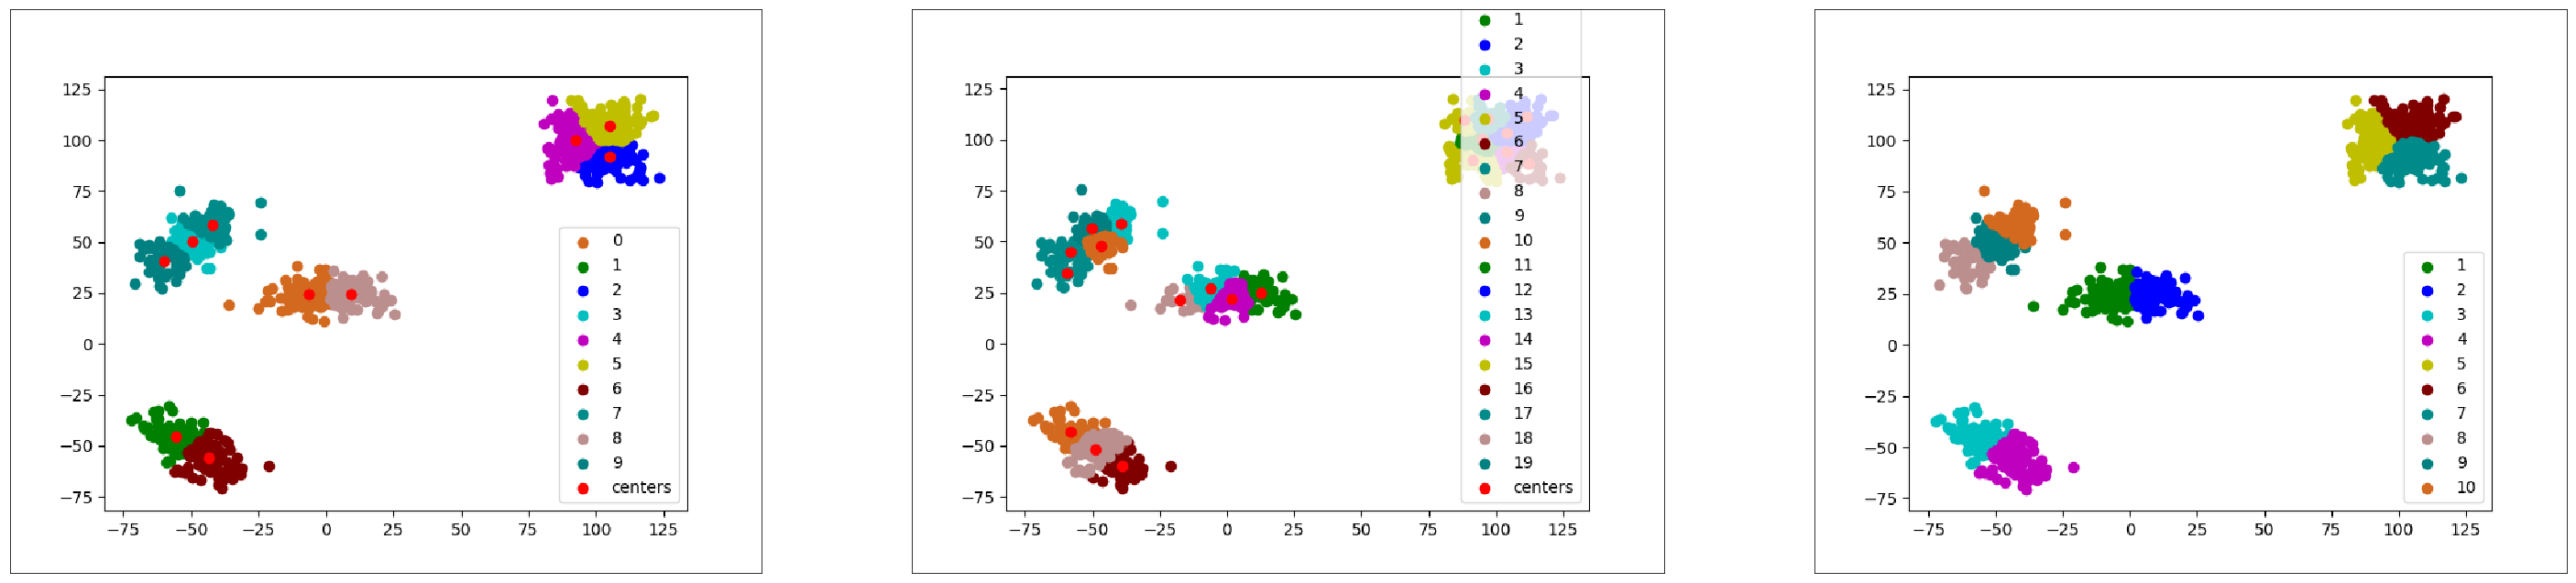

In [5]:
run_with_diameter_constraint(2)



Executing  sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus              --points-file data/points-N200-d50.txt --k-means-k 10 -o -d results-4
Executing  sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus              --points-file data/points-N200-d50.txt --k-means-k 20 -o -d results-4
Clustering comparison command: sbl-cmp-clust-dfam.exe -f results-4/sbl-cluster-k-means-euclid__f_points-N200-d50__mode_plusplus__iter_max_10__k_10__clusters.txt -f results-4/sbl-cluster-k-means-euclid__f_points-N200-d50__mode_plusplus__iter_max_10__k_20__clusters.txt --diameter-constraint 4 --num-iterations 100 -d results-4
Cluster display command for meta clustering: sbl-clusters-display.py  -f data/points-N200-d50.txt -c results-4/final-clustering.txt -o results-4
Figs displayed
XML: 1 / 1 files were loaded

Score of the matching: 925
Num meta clusters: 7
Num of clusters in each meta-clusters: [4, 4, 2, 4, 8, 6, 2]


'results-4'

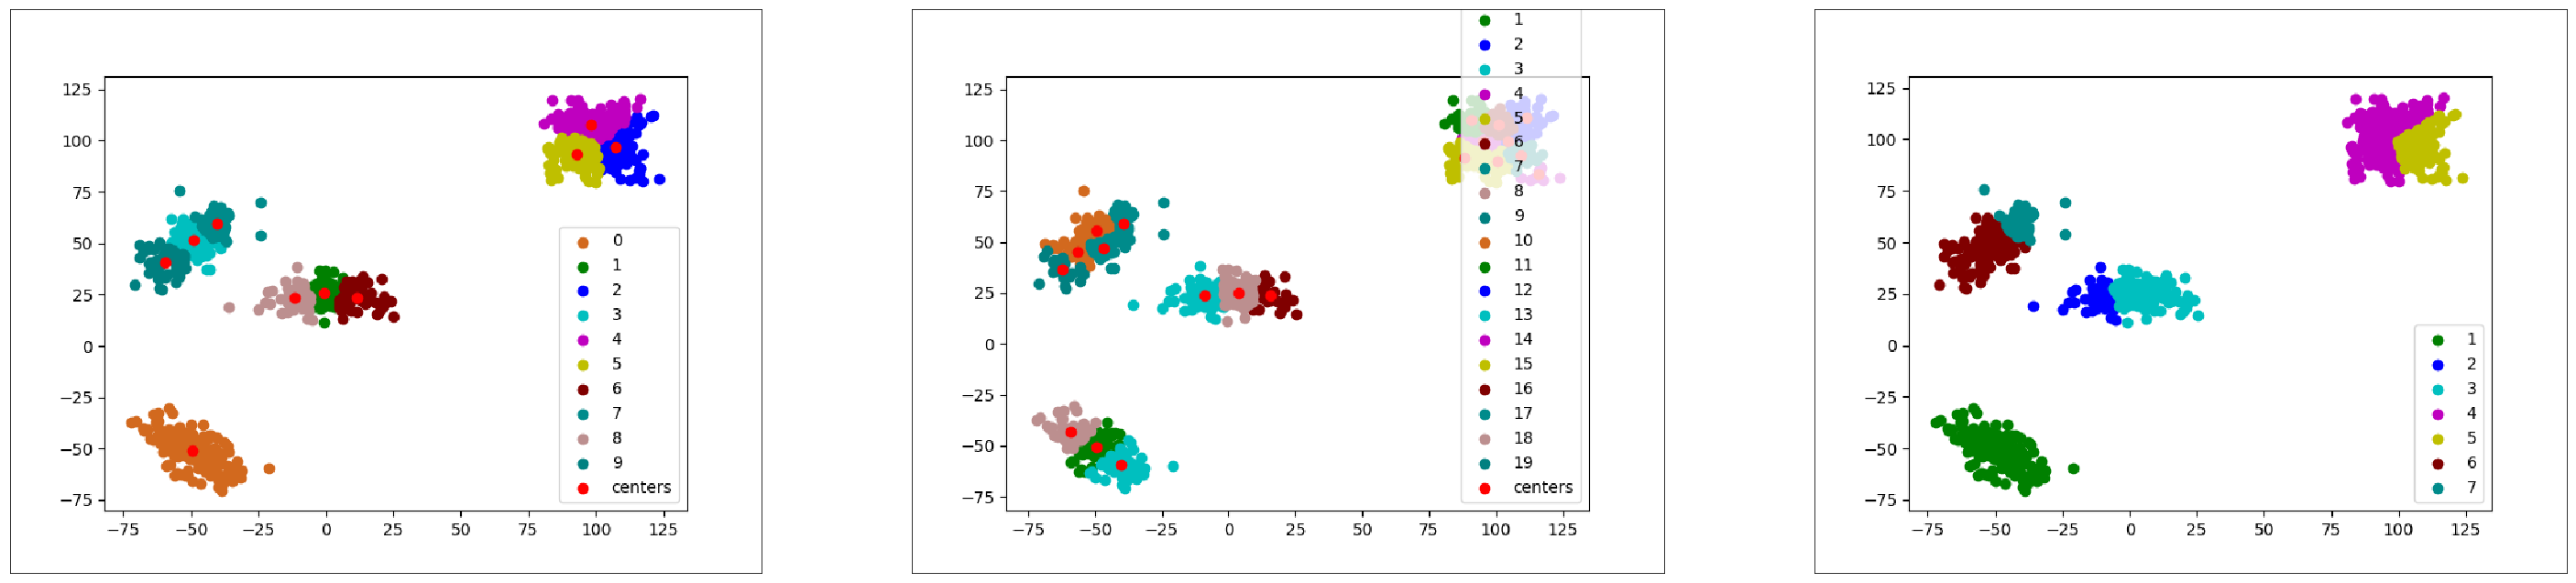

In [6]:
run_with_diameter_constraint(4)

Executing  sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus              --points-file data/points-N200-d50.txt --k-means-k 10 -o -d results-8
Executing  sbl-cluster-k-means-euclid.exe --k-means-selector=plusplus              --points-file data/points-N200-d50.txt --k-means-k 20 -o -d results-8
Clustering comparison command: sbl-cmp-clust-dfam.exe -f results-8/sbl-cluster-k-means-euclid__f_points-N200-d50__mode_plusplus__iter_max_10__k_10__clusters.txt -f results-8/sbl-cluster-k-means-euclid__f_points-N200-d50__mode_plusplus__iter_max_10__k_20__clusters.txt --diameter-constraint 8 --num-iterations 100 -d results-8
Cluster display command for meta clustering: sbl-clusters-display.py  -f data/points-N200-d50.txt -c results-8/final-clustering.txt -o results-8
Figs displayed
XML: 1 / 1 files were loaded

Score of the matching: 1000
Num meta clusters: 4
Num of clusters in each meta-clusters: [8, 5, 10, 7]


'results-8'

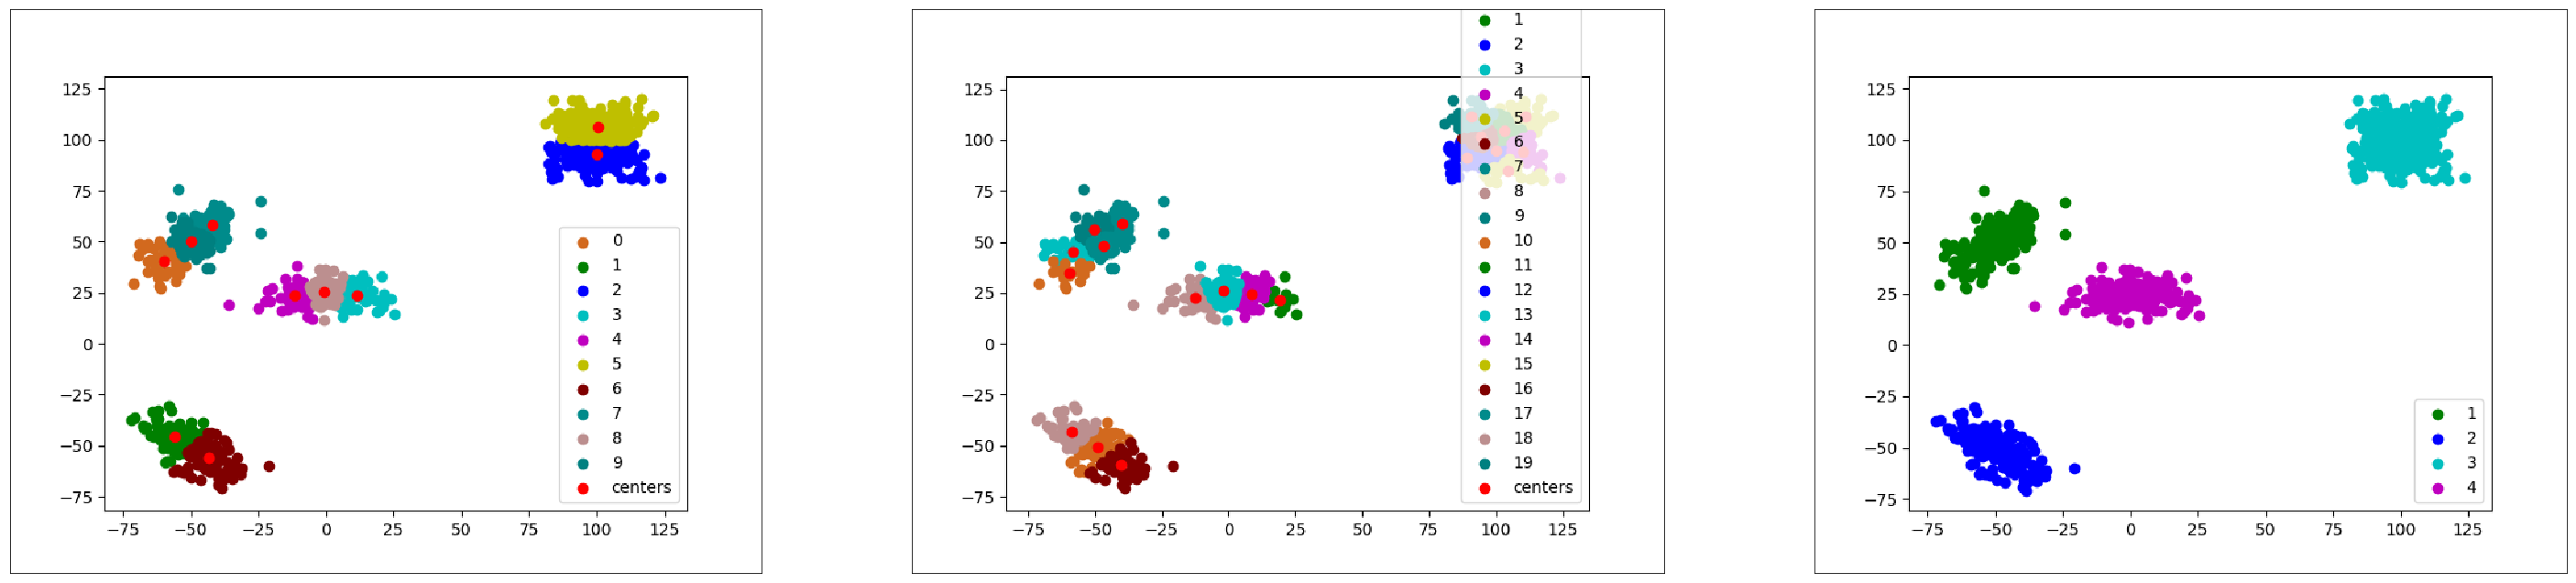

In [7]:
run_with_diameter_constraint(8)